# *Integración numérica* # 

---

## *Introducción* ##

En esta práctica se pretende emplear métodos de cuadratura para estudiar la energía diaria a partir de unos datos de irradiancia dados tanto en un día soleado como en un día nublado. Para ello se tomarán en consideración diversos intervalos temporales. \\

Primero se plantearán tres métodos para integrar una función conocida (método del trapecio, método de Romberg y método de Gauss) y tras obtener resultados satisfactorios, se aplicarán los que sean posibles al problema planteado con anterioridad.




In [78]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
def func(t):
  return np.exp(0.2*t) * np.sin(t)
vex = -2.981778822684376 #valor exacto de la integral

El valor exacto da la integral a aproximar es
\begin{equation}
\int_{-6}^6 e^{0.2t}\sin(t) dx \approx −2.981778822684376
\end{equation}

---

## *1. Caso general de una función conocida* ##


### *1.1. Método* ###

Para empezar, se usará el **método del trapecio** como método de Newton-Cotes. Geométricamente, este método consiste en sustituir la función a integrar por la recta que pasa por los puntos $(a, f(a))$ y $(b, f(b)$ y calcular el área del trapecio correspondiente. 
\begin{equation}
I_n(f) = \frac{b-a}{2} (f(a) + f(b))
\end{equation}
siendo a y b los extremos del intervalo y $h = b - a$. Se puede **mejorar** el método usando una cuadratura compuesta, es decir, dividimos el intervalo en varios subintervalos y aplicamos este método en cada subintervalo. De este modo, diviendo en n subintervalos escribimos que, con $h = \frac{b-a}{n}$, 
\begin{equation}
I_n(f) = \frac{b-a}{2} \sum_{j=0}^{n-1} (f(x_{j+1}) + f(x_j))
\end{equation}
con $x_{j+1}$ y $x_j$ los nodos de cada subintervalo. Se definirá la función $\textit{nods}$ que calcule los nodos necesarios en función de los intervalos que se requieran, así como su imagen, ya que serán necesarios para el posterior análisis de datos. Será la función $\textit{trap1}$ la que aplique la regla del trapecio a los subintervalos formados por dichos nodos.  

In [80]:
def nods(f, a, b, n): 
  h = (b - a)/n
  nodos = np.array([a])
  for i in range(n):
    nodos = np.append(nodos, nodos[i]+h) #nodos equiespaciados
  pesos = f(nodos) #imagenes
  return nodos, pesos

def trap1(f, a, b, n): #regla trapezoidal compuesta
  h = (b - a)/n
  suma = 0.
  for i in range(n):
    suma += h/2*(f(a+i*h) + f(a+(i+1)*h))
  return suma

Ahora se aplicará el **método de Romberg**, que acelera la convergencia de la regla trapezoidal compuesta. Para ello, se realiza la integración con la regla trapezoidal compuesta con n subdivisiones del intervalo y se subdivide a su vez cada intervalo a la mitad. Si se reitera este proceso se llega a una sucesión de fórmulas de cuadratura, que es lo que se conoce como método de Romberg. Visualmente se representa como
\begin{equation}
\begin{matrix}
I_{0(1)} & & & &  \\
I_{0(2)} & I_{1(2)} & & &  \\
I_{0(4)} & I_{1(4)} & I_{2(4)} & & \\
I_{0(8)} & I_{1(8)} & I_{2(8)} & I_{3(8)} & \\
\vdots & \vdots & \vdots & \vdots & \ddots \\
\end{matrix}
\end{equation}
donde la primera columna corresponde a los valores calculados con la regla trapezoidal compuesta y el resto de términos se calculan como 
\begin{equation}
I_{k(2n)} = \frac{4^kI_{k-1(2n)} - I_{k-1(n)}}{4^k-1}
\end{equation}

Se creará la función $\textit{Romberg1}$, donde se usará el método del trapecio ya programado para subidivisiones del intervalo siguiendo la sucesión 1, 2, 4, 8, ..., hasta la precisión requerida. A partir de esto se aplicará el método de Romberg

In [81]:
def Romberg1(aprox, f, a, b, n, precsn): 
  i = 1
  col1 = np.array([])
  while (abs(aprox(f, a, b, 2*i) - aprox(f, a, b, i)) > precsn): #aplicación del método del trapecio a la precision requerida
    col1 = np.append(col1, aprox(f, a, b, i))
    i *= 2
  m = np.zeros((len(col1), len(col1)))
  m[:,0] = col1
  for i in range(1,len(col1)):
    for j in range(i, len(col1)):
      m[j,i] = (4**i*m[j,i-1] - m[j-1,i-1])/(4**i-1) #método de Romberg
  return m

Para el **método de Gauss** se plantea para encontrar la distribución de nodos y pesos que hagan que la fórmula de cuadratura tenga grado de precisión los más alto posible. De forma general, se hará el siguiente cambio
\begin{equation}
\int_{\alpha}^{\beta} f(x)dx \; \rightarrow \; \int_{-1}^1 f(t)dt
\end{equation}

donde se hará el cambio lineal $t = ax + b$. Este cambio será $-1 = \alpha a + b$ y $1 = \beta a + b$. Resolviendo para a y b
\begin{equation}
a = \frac{2}{\beta- \alpha} \quad ; \quad b = \frac{\alpha + \beta}{\alpha- \beta}
\end{equation}
La función conocida cambiará a $f(x) = f \left(\frac{t-b}{a}\right)$, y el diferencial será $dt = adx$. Veamos ahora la aplicación a la función planteada en esta práctica $f(t)$.
\begin{equation}
\int_{-6}^6 e^{0.2t}\sin(t) dt =  6\int_{-1}^1 e^{1.2x}sin(6x)dx
\end{equation}

Planteamos el método de Gauss de forma general, que contedrá los cambios de variable planteados. De este modo, tenemos el método planteado para cualquier función f(t) y para unos límites cualesquiera $\alpha$ y $\beta$. Posteriormente se plantea una función que vaya aplicando el método a cada vez más subintervalos buscando la precisión planteada. Para ello se recurrirá a la función de nodos ya planteada anteriormente.


In [82]:
def Gauss(f, alfa, beta): #método de Gauss para un intervalo
  a = 2/(beta - alfa)
  b = (alfa + beta)/(alfa - beta)
  suma = 1/a*(f((-1/np.sqrt(3) - b)/a) + f((1/np.sqrt(3) - b)/a))
  return suma

In [83]:
def precision(g, f, n1, alfa, beta, n): #método de "Gauss compuesto" (aplicación a varios subintervalos) 
  suma = 0.
  for i in range(len(n1(f, alfa, beta, n)[0])-1):
    suma += g(f, n1(f, alfa, beta, n)[0][i], n1(f, alfa, beta, n)[0][i+1])
  return suma

### *1.2. Resultados y análisis* ###
A mayor número de intervalos el resultado debe ir convergiendo al valor esperado, por lo que exigimos que vaya probando intervalos hasta que la diferencia entre números de intervalos consecutivos sea poco apreciable (elegiremos una diferencia de $10^{-6}$, que da un resultado preciso sin ralentizar la ejecución de forma apreciable). Con el método del trapecio compuesto se obtiene

In [84]:
i = 1
while (abs(trap1(func, -6, 6, i+1) - trap1(func, -6, 6, i)) > 1e-6):
  i += 1

print("En la aproximación para " + str(i+1) + " intervalos se obtiene " + str(trap1(func, -6, 6, i+1)) + \
      ", que difiere en " + str(np.round(abs(vex - trap1(func, -6, 6, i+1)), decimals=4)) + " del resultado esperado.")

En la aproximación para 402 intervalos se obtiene -2.981578604463489, que difiere en 0.0002 del resultado esperado.


Veamos si el método de Romberg mejora la convergencia del método del trapecio. Para ello requerimos una precisión de $10^{-6}$. Se espera que el término n-ésimo calculado por el método del trapecio para dicha precisión sea menos preciso que el calculado por el método de Romberg, es decir, el término de la diagonal con la misma n 

In [85]:
print("El término de la diagonal es " + str(Romberg1(trap1, func, -6, 6, i, 1e-6)[-1,-1]) + " y el de la misma n calculado " + \
      "por la regla del trapecio es " + str(Romberg1(trap1, func, -6, 6, i, 1e-6)[-1,0]))
print()
print("El término calculado por la regla del trapecio compuesta difiere en " + str(abs(vex - Romberg1(trap1, func, -6, 6, i, 1e-6)[-1,0])) + \
      " del valor esperado")
print()
print("El término calculado por el método de Romberg difiere en " + str(abs(vex - Romberg1(trap1, func, -6, 6, i, 1e-6)[-1,-1])) + \
      " del valor esperado")

El término de la diagonal es -2.981778822684374 y el de la misma n calculado por la regla del trapecio es -2.9817768941331257

El término calculado por la regla del trapecio compuesta difiere en 1.928551250252042e-06 del valor esperado

El término calculado por el método de Romberg difiere en 1.7763568394002505e-15 del valor esperado


Veamos ahora cuanto difiere el resultado calculado por el método de Gauss del resultado esperado.

In [86]:
i = 1
while (abs(precision(Gauss, func, nods, -6, 6, i+1) - precision(Gauss, func, nods, -6, 6, i)) > 1e-6):
  i += 1
print("Con el método de Gauss se obtiene " + str(precision(Gauss, func, nods, -6, 6, i+1)) + " que difiere en " +\
      str(abs(vex - precision(Gauss, func, nods, -6, 6, i+1))) + " del valor esperado.")

Con el método de Gauss se obtiene -2.981771800128754 que difiere en 7.022555621905013e-06 del valor esperado.


Para analizar visualmente los resultados obtenidos en función de los intervalos seleccionados, graficaremos la aproximación bajo la curva. Ya sabemos que la interpretación geométrica del método del trapecio es sustituir la función a integrar por la recta que pasa por los puntos $(a, f(a))$ y $(b, f(b)$ y calcular el área del trapecio correspondiente. \\

Para una representación gráfica del resultado, se hará un histograma representando el área que se calcula en cada intervalo con el método trapezoidal compuesto y sobre este la curva teórica. Representaremos la aproximación tomando 10, 20, 60 y 200 intervalos

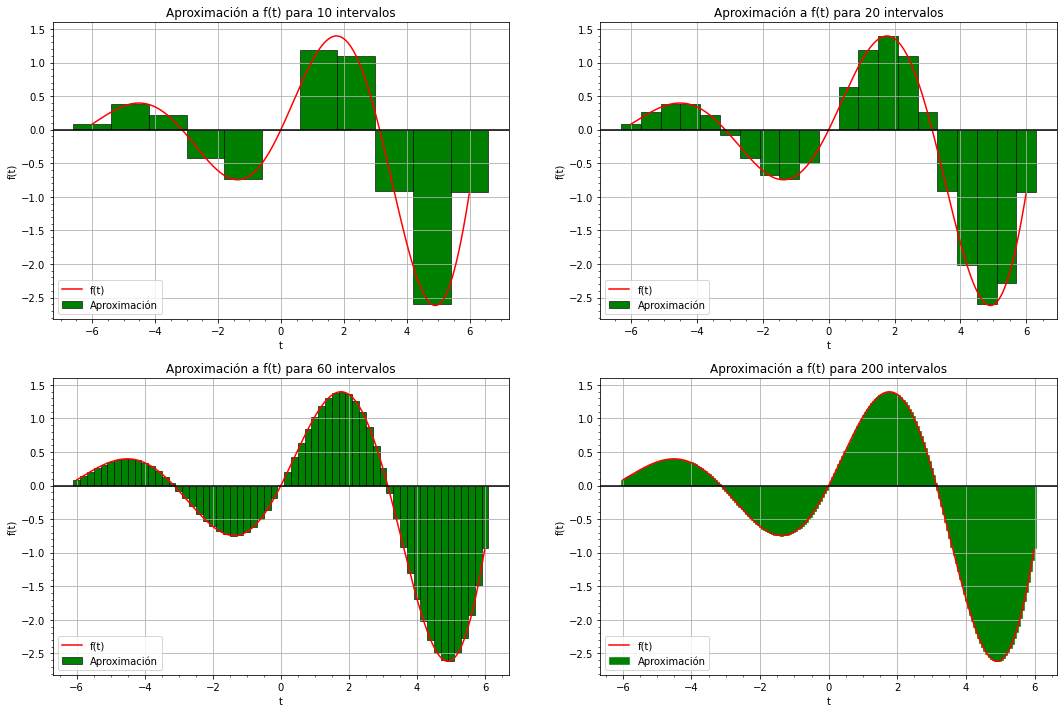

In [87]:
x = np.arange(-6, 6, 0.01)

fig1, ax1 = plt.subplots(2, 2, figsize=(18, 12))

ax1[0,0].plot(x, func(x), color='r', label="f(t)") #funcion
ax1[0,0].bar(nods(func, -6, 6, 10)[0], height=nods(func, -6, 6, 10)[1], width=1.2, align='center', color='g', edgecolor='k', \
             linewidth=0.6, label='Aproximación') #histograma
ax1[0,0].axhline(y=0, xmin=-7, xmax=7, color='k')
ax1[0,0].set_title('Aproximación a f(t) para 10 intervalos')
ax1[0,0].minorticks_on()
ax1[0,0].set_xlabel("t")
ax1[0,0].set_ylabel("f(t)")
ax1[0,0].grid()
ax1[0,0].legend(loc='lower left')

ax1[0,1].plot(x, func(x), color='r', label="f(t)") #funcion
ax1[0,1].bar(nods(func, -6, 6, 20)[0], height=nods(func, -6, 6, 20)[1], width=0.6, align='center', color='g', edgecolor='k', \
             linewidth=0.6, label='Aproximación') #histograma
ax1[0,1].axhline(y=0, xmin=-7, xmax=7, color='k') 
ax1[0,1].set_title('Aproximación a f(t) para 20 intervalos')
ax1[0,1].minorticks_on()
ax1[0,1].set_xlabel("t")
ax1[0,1].set_ylabel("f(t)")
ax1[0,1].grid()
ax1[0,1].legend(loc='lower left')

ax1[1,0].plot(x, func(x), color='r', label='f(t)') #funcion
ax1[1,0].bar(nods(func, -6, 6, 60)[0], height=nods(func, -6, 6, 60)[1], width=0.2, align='center', color='g', edgecolor='k', \
             linewidth=0.6, label='Aproximación') #histograma
ax1[1,0].axhline(y=0, xmin=-7, xmax=7, color='k')
ax1[1,0].set_title('Aproximación a f(t) para 60 intervalos')
ax1[1,0].minorticks_on()
ax1[1,0].set_xlabel("t")
ax1[1,0].set_ylabel("f(t)")
ax1[1,0].grid()
ax1[1,0].legend(loc='lower left')

ax1[1,1].plot(x, func(x), color='r', label='f(t)') #funcion
ax1[1,1].bar(nods(func, -6, 6, 200)[0], height=nods(func, -6, 6, 200)[1], width=0.1, align='center', color='g', edgecolor='g', \
             linewidth=0.6, label='Aproximación') #histograma
ax1[1,1].axhline(y=0, xmin=-7, xmax=7, color='k')
ax1[1,1].set_title('Aproximación a f(t) para 200 intervalos')
ax1[1,1].minorticks_on()
ax1[1,1].set_xlabel("t")
ax1[1,1].set_ylabel("f(t)")
ax1[1,1].grid()
ax1[1,1].legend(loc='lower left')

Se obtiene el resultado esperado en todos los casos. Con Romberg obtenemos una convergencia acelerada, siendo que para la misma n se calcula un valor que coincide en 14 decimales con el valor exacto, mientras con el método trapezoidal compuesto lo hace en 6 decimales. Con el método de Gauss también obtenemos un resultado satisfactorio. \\

En vista de los buenos resultados se representan únicamente los resultados obtenidos por la regla trapezoidal compuesta para ciertos intervalos de modo que se aprecie la tendencia. Queda claro que a mayor número de intervalos, la aproximación del área converge al valor esperado. 

## *2. Aplicación a los datos de irradiancia* ##

### *2.1. Método* ###

A continuación, se aplicarán los métodos que se puedan a los datos de irradiancia. En este caso no se conoce la función que siguen los datos, por lo que se está limitado por los datos dados en los arrays anteriores. Se conoce únicamente el valor de la función en las horas dadas en $\textit{times}$, por lo que a la hora de tomar subintervalos (añadir nodos entre los extremos del intervalo de horas) se estará limitado. Esto implica que se podrá dividir el intervalo de horas (desde las 7:00 hasta las 18:50 según los datos en $\textit{times}$) hasta un máximo de 10 en 10 minutos. \\

Con este razonamiento, queda en evidencia que los métodos de Romberg y Gauss planteados no son viables para este caso, por lo que solo se aplicará la regla trapezoidal compuesta.

In [88]:
times=[7.000, 7.167, 7.333, 7.500, 7.667, 7.833, 8.000, 8.167, 8.333, 8.500, 8.667, 8.833, 
      9.000, 9.167, 9.333, 9.500, 9.667, 9.833, 10.000, 10.167, 10.333, 10.500, 10.667, 
      10.833, 11.000, 11.167, 11.333, 11.500, 11.667, 11.833, 12.000, 12.167, 12.333, 12.500, 
      12.667, 12.833, 13.000, 13.167, 13.333, 13.500, 13.667, 13.833, 14.000, 14.167, 14.333, 
      14.500, 14.667, 14.833, 15.000, 15.167, 15.333, 15.500, 15.667, 15.833, 16.000, 16.167, 
      16.333, 16.500, 16.667, 16.833, 17.000, 17.167, 17.333, 17.500, 17.667, 17.833, 18.000, 
      18.167, 18.333, 18.500, 18.667, 18.833]
irrad_clear=[0.000, 0.000, 0.000, 0.000, 21.612, 55.383, 93.096, 132.441, 172.396, 212.452, 
             252.250, 291.606, 330.281, 368.001, 404.668, 439.920, 473.835, 506.128, 537.063, 
             566.333, 593.944, 620.119, 644.824, 668.009, 689.988, 709.855, 728.081, 745.072, 
             759.743, 772.286, 783.537, 792.232, 799.269, 804.334, 807.315, 808.342, 807.393, 
             804.731, 799.940, 793.243, 784.319, 773.072, 759.817, 744.682, 728.159, 709.760, 
             689.663, 667.544, 644.051, 618.862, 591.916, 563.418, 533.703, 502.093, 469.306, 
             435.198, 400.214, 364.514, 327.855, 290.572, 252.548, 214.099, 175.268, 136.569, 
             98.376, 61.651, 28.276, 3.183, 0.000, 0.000, 0.000, 0.000]
irrad_cloudy=[0.000, 0.000, 0.000, 0.000, 17.179, 45.325, 78.286, 113.505, 
             149.812, 186.590, 223.418, 259.982, 292.285, 234.778, 366.404, 
             395.085, 332.836, 403.859, 394.608, 295.554, 217.329, 155.561, 
             121.025, 125.947, 127.421, 132.406, 145.540, 155.227, 155.719, 
             165.672, 182.377, 187.410, 194.783, 248.071, 280.528, 187.896, 
             147.067, 170.616, 200.454, 211.792, 237.796, 268.225, 283.406, 
             328.017, 640.643, 669.319, 260.384, 195.084, 192.337, 156.368, 
             104.883, 110.625, 124.012, 138.354, 127.643, 109.215, 112.728, 
             202.107, 104.074, 69.630, 59.437, 34.575, 23.116, 16.588, 11.083, 
             6.456, 3.391, 0.491, 0.000, 0.000, 0.000, 0.000]

Se debe rediseñar la función planteada para el caso de una función generica $f(t)$, y adaptarla para que tome los datos de los arrays anteriores, pudiendo elegir el intervalo de tiempo (con las limitaciones planteadas anteriormente) con el que se espacian las medidas. \\

De forma completamente análoga a la función $\textit{trap1}$, se plantea la función $\textit{trap}$, a la que se le pasarán como parámetros el array $\textit{times}$ y los de irradiancia, además de un número n que será el espaciado temporal a tomar, lo que marcará el número de intervalos. 

In [89]:
def trap(datosx, datosy, n): #dependerá de los nodos y el espaciado entre ellos que se quiera tomar
  xnodes, ynodes = datosx[::n], datosy[::n] 
  h = (xnodes[-1] - xnodes[0])/(len(xnodes)-1)
  suma = 0.
  for i in range(len(xnodes)-1):
    suma += (ynodes[i] + ynodes[i+1])*3600 #pasar de horas a segundos
  return suma*h/2

Para evaluar la regla trapezoidal compuesta, al no disponer de la función que siguen los datos, no se buscará un resultado con una precisión dada, sino que se tomarán en consideración diversos intervalos temporales. Se aplicará tanto para el día soleado como para el día nublado. \\

Para ello se define la función $\textit{estimacion}$, la cual dependerá del método de Newton-Cotes que se quiera usar (en esta práctica solo se plantea el método del trapecio), así como de la cantidad de datos totales disponible ($\textit{times}$ y los array de irradiancia) y la longitud deseada para los intervalos temporales, por lo que a mayor longitud, menos intervalos habrá disponibles. Esta función devolverá dos arrays que facilitarán la visualización de los resultados obtenidos.


In [90]:
def estimacion(f, datosx, datosy, n): #dependerá de los nodos y el espaciado entre ellos que se quiera tomar
  horas = np.array([0.167])
  irrad = np.array([f(datosx, datosy, 1)])
  for i in range(n, len(datosx), n):
    horas = np.append(horas, i/6)
    irrad = np.append(irrad, f(datosx, datosy, i))
  return horas, irrad

### *2.2. Resultados y análisis irradiancia* ###

Como muestra representativa, se ha decidido estudiar el resultado de la energía total variando los intervalos en 1 hora. A excepción del primer cálculo, que se hace con todos los datos disponibles, se hará esl estudio con datos dispersos en una hora, dos horas, etc; hasta tomar una separación máxima de 11 horas entre nodos. \\

Para una buena visualización de los resultados obtenidos, se muestran en un histograma. En el eje x se representa el tiempo entre nodos (longitud intervalos temporales), por lo que la barra más a la izquierda corresponde a tomar el array $\textit{times}$ completo y la que se sitúa en el extremo derecho corresponde a tomar los datos de los arrays disponibles cada 11 horas. En el eje y se tendrá la energía total calculada para ese día a partir de los datos disponibles. 


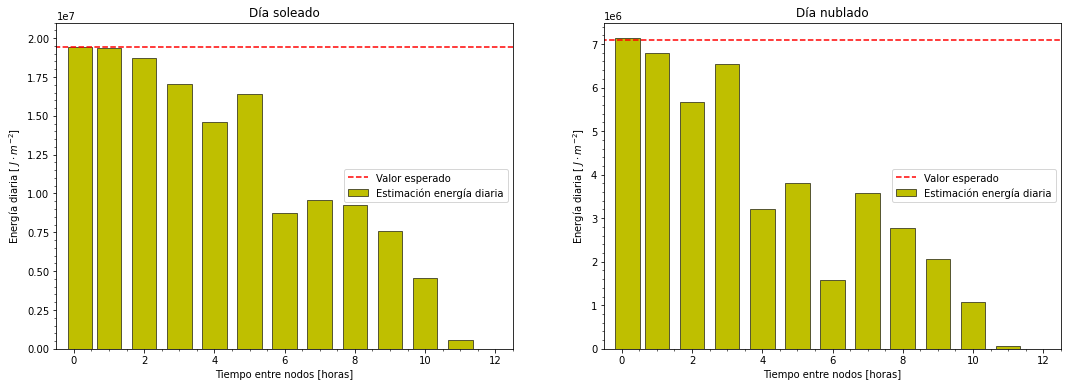

In [98]:
fig1, ax1 = plt.subplots(1, 2, figsize=(18, 6))

ax1[0].bar(estimacion(trap, times, irrad_clear, 6)[0], height=estimacion(trap, times, irrad_clear, 6)[1], width=0.7, align='center', \
           color='y', edgecolor='k', linewidth=0.6, label='Estimación energía diaria')
ax1[0].axhline(y=19415316, xmin=-1, xmax=12.5, color='r', linestyle='--', label="Valor esperado")
ax1[0].set_title('Día soleado')
ax1[0].minorticks_on()
ax1[0].set_xlabel("Tiempo entre nodos [horas]")
ax1[0].set_ylabel("Energía diaria [ $J\cdot m^{-2}$]")
ax1[0].set_xlim(-0.5, 12.5)
ax1[0].set_ylim(0, 2.1e7)
ax1[0].legend()

ax1[1].bar(estimacion(trap, times, irrad_cloudy, 6)[0], height=estimacion(trap, times, irrad_cloudy, 6)[1], width=0.7, align='center', \
           color='y', edgecolor='k', linewidth=0.6, label='Estimación energía diaria')
ax1[1].axhline(y=7093022, xmin=-1, xmax=12.5, color='r', linestyle='--', label="Valor esperado")
ax1[1].set_title('Día nublado')
ax1[1].minorticks_on()
ax1[1].set_xlabel("Tiempo entre nodos [horas]")
ax1[1].set_ylabel("Energía diaria [ $J\cdot m^{-2}$]")
ax1[1].set_xlim(-0.5, 12.5)
#ax1[1].set_ylim(0, 7.7e6)
ax1[1].legend()


Aquí se podrá hacer un análisis similar al realizado para la función matemática conocida. Si bien la convergencia no es uniforme ante el aumento de intervalos, se observa en la tendencia como la convergencia es al valor esperado en ambos casos. Se destaca la mayor irregularidad de los resultados para el día nublado, fenómeno ya observado en la interpolación de dichos datos en otra práctica. 